### Implementation of Encoder-Decoder

This code implements the Encoder-Decoder architecture using Bahadanau attention mechanism.

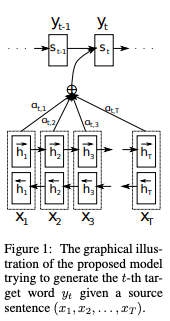

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, GRU, Embedding, Dense

In [3]:
class BahadanauAttention(Layer):
    def __init__(self, n_units):

        super(BahadanauAttention, self).__init__()
        self.n_units = n_units

    def __build__(self):

        self.W = Dense(self.n_units) # for h
        self.U = Dense(self.n_units) # for y
        self.V = Dense(1)

    def __call__(self, hidden, y):

        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        score = self.V(tf.nn.tanh(
            self.W(hidden_with_time_axis) + self.U(y)))

        weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(weights * y, axis=1)

        return context_vector, weights

In [1]:
class Encoder(Model):

    def __init__(self, batch_size, n_units, vocab_size, embed_dim):
        
        super(Encoder, self).__init__()
    
        # hyperparameters
        self.batch_size = batch_size
        self.n_units = n_units
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # layers
        self.embedding = Embedding(vocab_size, embed_dim)
        self.gru = GRU(n_units, 
                       return_sequence=True,
                       return_state=True,
                       recurrent_initializer='glorot_uniform')

    def __call__(self, inputs, initial_hidden):

        x = self.embedding(inputs)
        y, hidden = self.gru(x)

        return y, hidden

In [5]:
class Decoder(Model):

    def __init__(self, batch_size, n_units, vocab_size, embed_dim):
        
        super(Decoder, self).__init__()
    
        # hyperparameters
        self.batch_size = batch_size
        self.n_units = n_units
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # layers
        self.embedding = Embedding(vocab_size, embed_dim)
        self.attention = BahadanauAttention(n_units)
        self.GRU(n_units,
                 return_sequence=True,
                 return_state=True,
                 recurrent_initializer='glorot_uniform')
        self.output = Dense(vocab_size, activation='softmax')

    def __call__(self, inputs, hidden, y):

        x = self.embedding(inputs)
        context_vector, weights = self.attention(hidden, y)

        # compute attention vector
        x = tf.concat([tf.expand_dims(context_vector, axis=1), x], axis=-1)

        y_dec, hidden_dec = self.gru(x)
        y_dec = tf.reshape(y_dec, (-1, y_dec.shape[-1]))

        # word prediction
        y = self.output(y_dec)
        
        return y, hidden_dec, weights